<a href="https://colab.research.google.com/github/rhiats/TIHM-Dataset-RNN/blob/main/RNN_TIHM_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

**Read Data**

In [2]:
dataframe = pd.read_csv("/content/drive/MyDrive/TIHM_Dataset/Dataset/Sleep.csv")

In [3]:
dataframe.shape

(461423, 6)

In [4]:
dataframe.head()

,patient_id,date,state,heart_rate,respiratory_rate,snoring
0,0f352,2019-06-25 22:53:00,AWAKE,69.0,14.0,False
1,0f352,2019-06-25 22:54:00,AWAKE,66.0,14.0,False
2,0f352,2019-06-25 22:55:00,AWAKE,70.0,14.0,False
3,0f352,2019-06-25 22:56:00,AWAKE,70.0,13.0,False
4,0f352,2019-06-25 22:57:00,AWAKE,68.0,13.0,False


In [5]:
dataframe.sort_values(['patient_id', 'date'], ascending=[True, True])

,patient_id,date,state,heart_rate,respiratory_rate,snoring
0,0f352,2019-06-25 22:53:00,AWAKE,69.0,14.0,False
1,0f352,2019-06-25 22:54:00,AWAKE,66.0,14.0,False
2,0f352,2019-06-25 22:55:00,AWAKE,70.0,14.0,False
3,0f352,2019-06-25 22:56:00,AWAKE,70.0,13.0,False
4,0f352,2019-06-25 22:57:00,AWAKE,68.0,13.0,False
...,...,...,...,...,...,...
461418,f220c,2019-06-30 10:47:00,AWAKE,76.0,20.0,False
461419,f220c,2019-06-30 10:48:00,AWAKE,73.0,21.0,False
461420,f220c,2019-06-30 10:49:00,AWAKE,65.0,18.0,False
461421,f220c,2019-06-30 10:50:00,AWAKE,75.0,15.0,False


In [6]:
features = ['heart_rate', 'respiratory_rate']
target = ['snoring']
scaler = MinMaxScaler()
dataframe[features] = scaler.fit_transform(dataframe[features])

dataframe.head()

,patient_id,date,state,heart_rate,respiratory_rate,snoring
0,0f352,2019-06-25 22:53:00,AWAKE,0.449275,0.260870,False
1,0f352,2019-06-25 22:54:00,AWAKE,0.405797,0.260870,False
2,0f352,2019-06-25 22:55:00,AWAKE,0.463768,0.260870,False
3,0f352,2019-06-25 22:56:00,AWAKE,0.463768,0.217391,False
4,0f352,2019-06-25 22:57:00,AWAKE,0.434783,0.217391,False


In [7]:
print(len(dataframe[features].values))

461423


**Random Sample**

In [8]:
df = dataframe.sample(frac=0.01)

In [9]:
df.shape

(4614, 6)

**Create Sequences**

In [10]:
def create_sequences(data, target, seq_length=10):
    sequences = []
    labels = []

    #Create sequences of length 10
    for i in range(len(data) - seq_length):
      sequences.append(data[i:i+seq_length])
      labels.append(target[i+seq_length])
    return np.array(sequences), np.array(labels)

In [11]:
X, y = create_sequences(df[features].values, df[target].values)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

**RNN Model**

In [14]:
# Define RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # Initial hidden state
        out, hidden = self.rnn(x, h0) # Forward pass through RNN. Calls the RNN defined in __init__
        #print(f"RNN Output Shape: {out.shape}")  # (batch_size, seq_length, hidden_size)
        #print(f"Final Hidden State Shape: {hidden.shape}")  # (num_layers, batch_size, hidden_size)
        out = self.fc(out[:, -1, :])  # Output from last time step. Fully connected layer
        return out

**Model parameters**

In [15]:
input_size = len(features)
hidden_size = 32 #Compare 16 to 32
output_size = 1  # Regression or Binary classification

In [16]:
print(input_size)

2


**Model**

In [17]:
model = RNN(input_size, hidden_size, output_size)

**Loss using Binary Classification**

In [18]:
#criterion = nn.MSELoss()  # Use BCEWithLogitsLoss() for binary classification
criterion = nn.BCEWithLogitsLoss()

**Optimizer**

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

**Train the Model**

In [20]:
epochs = 100

# List to store loss values for each epoch
loss_values = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    #loss = criterion(outputs.squeeze(), y_train)
    loss = criterion(outputs.squeeze(), y_train.view(-1))

    # Store loss for plotting
    loss_values.append(loss.item())

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.7052
Epoch 10, Loss: 0.1686
Epoch 20, Loss: 0.1627
Epoch 30, Loss: 0.1611
Epoch 40, Loss: 0.1592
Epoch 50, Loss: 0.1590
Epoch 60, Loss: 0.1590
Epoch 70, Loss: 0.1590
Epoch 80, Loss: 0.1589
Epoch 90, Loss: 0.1589


**Plot Epoch vs Loss**

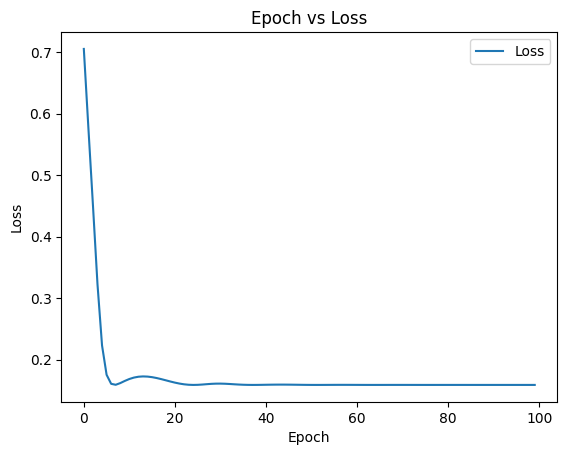

In [21]:
plt.plot(range(epochs), loss_values, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.show()

**Evaluate the model**

In [22]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze()
    y_test = y_test.squeeze()  # Removes the extra dimension
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.1757
